In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter
import math
import scipy.stats as ss
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [77]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15, 7))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.show()
    
def plot_confusion_matrix(y_test, y_pred):
    # define confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # define name of classes
    classes = unique_labels(y_test, y_pred)
    # define the plot of the confusion matrix
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="black" if cm[i, j] > thresh else "red")
    fig.tight_layout()
    plt.show()

# Import Dataset

In [2]:
# Importation of the JSON file and extract it into a dataframe
with open('jds_data_16102020.json') as json_data:
    data = json.load(json_data)
    
df = pd.DataFrame(data)
df_tags = df.tags.apply(pd.Series)
df.drop(['tags'], axis=1, inplace=True)
df = pd.concat([df, df_tags], axis=1)

The Dataset is composed of 50k items and 28 variables:
1. Title of the item.
2. Gender associated to the item.
3. Tags information which represents  category tags and their probability to be tagged.
   1. An item can be tagged 13 times at maximum.
   2. The same item can have different tags combinations.
        'Cat', 'Type', 'Look', 'Color', 'Texture', 'Style', 'Pattern', 'Detail', 'Embellishments', 'Length', 'Sleeve', 'Neckline', 'SleeveStyle'.

Each row is considered to be an event ( a sale for example) and the data stores the title of the item, the gender associated and a list of tags likely classified (by an item discovery model).

A tag can be not detected, in that situation the dataset stores it as NaN value for the tag and its probability. This elements are modified to be considered as a result of Product Discovery Model and have a probability of 0.

In [3]:
# Replacememt of NaN values by 'NotTagged' and its probabilty to 0
col_tags = []
col_tags_prob = []
for col in df.columns[2:]:
    if '_prob' in col:
        col_tags_prob.append(col)
        df[col].fillna(0, inplace=True)
    else:
        col_tags.append(col)
        df[col].fillna('NotTagged', inplace=True)

# General Insights

I focus on general observations about the data.
1. Male / Female representation
1. How the data stores the tags
2. Items reprsentations and their tags combinations

number of unique items:  23566
most item:  Basic Regular Fit Jogger 68


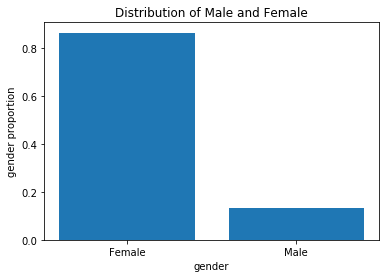

In [17]:
# number of unique Items
print('number of unique items: ', df.title.unique().shape[0])

# Most items sold
print('most item: ', df.title.value_counts().index[0], df.title.value_counts().values[0])

# proportion of male and female
s = df.gender.value_counts()
gender = s.index
gender_prob = s.values/s.sum()
plt.bar(gender, gender_prob)
plt.xlabel("gender") 
plt.ylabel("gender proportion") 
plt.title("Distribution of Male and Female") 
plt.show()

In [7]:
# visualization of the tags category order in the original Json file.
for j in range(20):
    print(data[j]['title'])
    for k,v in data[j]['tags'].items():
        if not '_prob' in k:
            print(k, data[j]['tags'][k+'_prob'])
    print('\n')

Woman Script Chunky Trainers
Cat 0.9999313354492188
Type 0.7146714925765991
Look 0.6681515574455261
Color 0.28177204728126526
Texture 0.09859316796064377
Style 0.01663399115204811


Woman Script Chunky Trainers
Cat 1.0
Type 0.9456222653388977
Look 0.9323696494102478
Color 0.41134366393089294
Style 0.019577834755182266
Texture 0.018719108775258064


Platform Retro Running Trainers
Cat 0.9994921684265137
Look 0.7480679750442505
Type 0.7167206406593323
Color 0.3409380316734314
Texture 0.18313579261302948
Pattern 0.06040370836853981
Style 0.04629015550017357


Zebra Panel Chunky Sole Trainer				
Cat 0.9986287951469421
Type 0.8606417775154114
Look 0.7555722594261169
Style 0.3604186475276947
Color 0.12443358451128006
Texture 0.06548354774713516
Pattern 0.02818404883146286
Detail 0.016393011435866356


Platform Retro Running Trainers
Cat 0.9999886751174927
Type 0.8485649824142456
Look 0.7575249075889587
Color 0.44447043538093567
Texture 0.31798169016838074
Style 0.17316456139087677
Pattern 0.

I notice that the tags' pairs are always sorted according to the probabilities of tags.

In [8]:
# Counts of items in the data
df.title.value_counts()

Basic Regular Fit Jogger                   68
Basic Crew Neck T-Shirt                    37
Basic Jersey Mini Skirt                    30
Recycled Metal Stud Earring Multi Pack     29
Maxi Dress                                 28
                                           ..
Roll Neck Cable Knit Jumper Dress           1
Spot Print Puff Sleeve Midi Smock Dress     1
Off The Shoulder Velvet Mini Dress          1
Basic Strappy Playsuit                      1
Plus Size Regular Denim Western Jacket      1
Name: title, Length: 23566, dtype: int64

Here I notice that some items have duplicates. For example 'Basic Regular Fit Jogger'. Moreover this item has different tags combinations and results.

In [9]:
# Tags category combination for the same item
df[df.title=='Basic Regular Fit Jogger'][['title']+col_tags]

,title,Cat,Type,Look,Color,Texture,Style,Pattern,Detail,Embellishments,Length,Sleeve,Neckline,SleeveStyle
15110,Basic Regular Fit Jogger,Trousers,Joggers,Casual,Orange,Velvet,Paperbag,NotTagged,Drawstrings,Distressed,AnkleLength,NotTagged,NotTagged,NotTagged
15112,Basic Regular Fit Jogger,Trousers,Joggers,Casual,DarkGray,NotTagged,Cargo,NotTagged,Drawstrings,NotTagged,AnkleLength,NotTagged,NotTagged,NotTagged
15135,Basic Regular Fit Jogger,Shirts,Joggers,Casual,White,Cotton,NotTagged,NotTagged,Drawstrings,Distressed,AnkleLength,NotTagged,NotTagged,NotTagged
15186,Basic Regular Fit Jogger,Trousers,Joggers,NotTagged,Natural,Velvet,Harem,NotTagged,Drawstrings,NotTagged,AnkleLength,NotTagged,NotTagged,NotTagged
15220,Basic Regular Fit Jogger,Trousers,Joggers,Sportive,Black,NotTagged,Harem,Stripes,Drawstrings,NotTagged,Cropped,NotTagged,NotTagged,NotTagged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31549,Basic Regular Fit Jogger,Trousers,Joggers,Sportive,White,Satin,Chinos,Stripes,Drawstrings,Distressed,AnkleLength,NotTagged,NotTagged,NotTagged
31584,Basic Regular Fit Jogger,Trousers,Joggers,NotTagged,LightGray,Velvet,Paperbag,Text,Drawstrings,Distressed,AnkleLength,NotTagged,NotTagged,NotTagged
31589,Basic Regular Fit Jogger,Trousers,Joggers,Sportive,Gray,Velvet,Harem,NotTagged,Drawstrings,NotTagged,Cropped,NotTagged,NotTagged,NotTagged
31604,Basic Regular Fit Jogger,Trousers,Joggers,Sportive,Black,NotTagged,Harem,Stripes,Drawstrings,NotTagged,AnkleLength,NotTagged,NotTagged,NotTagged


I notice that an item can have different list of category tags.

# Items insights

I want to see how the items' title is discriminant for the gender. I create a new variable 'items_words_cnt', is the count of word in each title's item.

## Male / Female items words count

In [11]:
# creation of the varibale items_words_cnt
df['items_words_cnt'] = df.title.apply(lambda t: len(t.split(' ')))

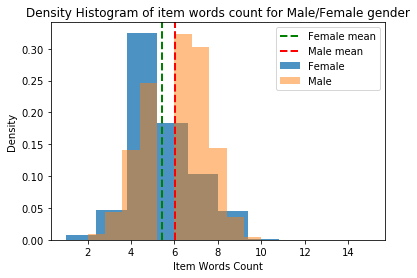

In [26]:
# plot items_words_cnt distribution according to the gender
xf = df[df.gender=='Female'].items_words_cnt 
xm = df[df.gender=='Male'].items_words_cnt

plt.hist(xf, density=True, alpha=0.8, label='Female')
plt.hist(xm, density=True, alpha=0.5, label='Male')

plt.axvline(xf.mean(), color='green', linestyle='dashed', linewidth=2, label='Female mean')
plt.axvline(xm.mean(), color='red', linestyle='dashed', linewidth=2, label='Male mean')

plt.title('Density Histogram of item words count for Male/Female gender')
plt.xlabel('Item Words Count')
plt.ylabel('Density')
plt.legend()
plt.show()

I remark that the items' words count distribution for Male and Female is different. Male's items have in average more words for describing their items. In addition, the median is also superior for Male's items

In [27]:
# median of items_words_cnt for female
df[df.gender=='Female'].items_words_cnt.median()

5.0

In [28]:
# median of items_words_cnt for male
df[df.gender=='Male'].items_words_cnt.median()

6.0

I assume that Female items are maybe more common than male' items, which they are more specific, so it uses more words to describe them.

This variable can be helpful to predict the gender.

## Male / Female items words frequency

Gender:  Female


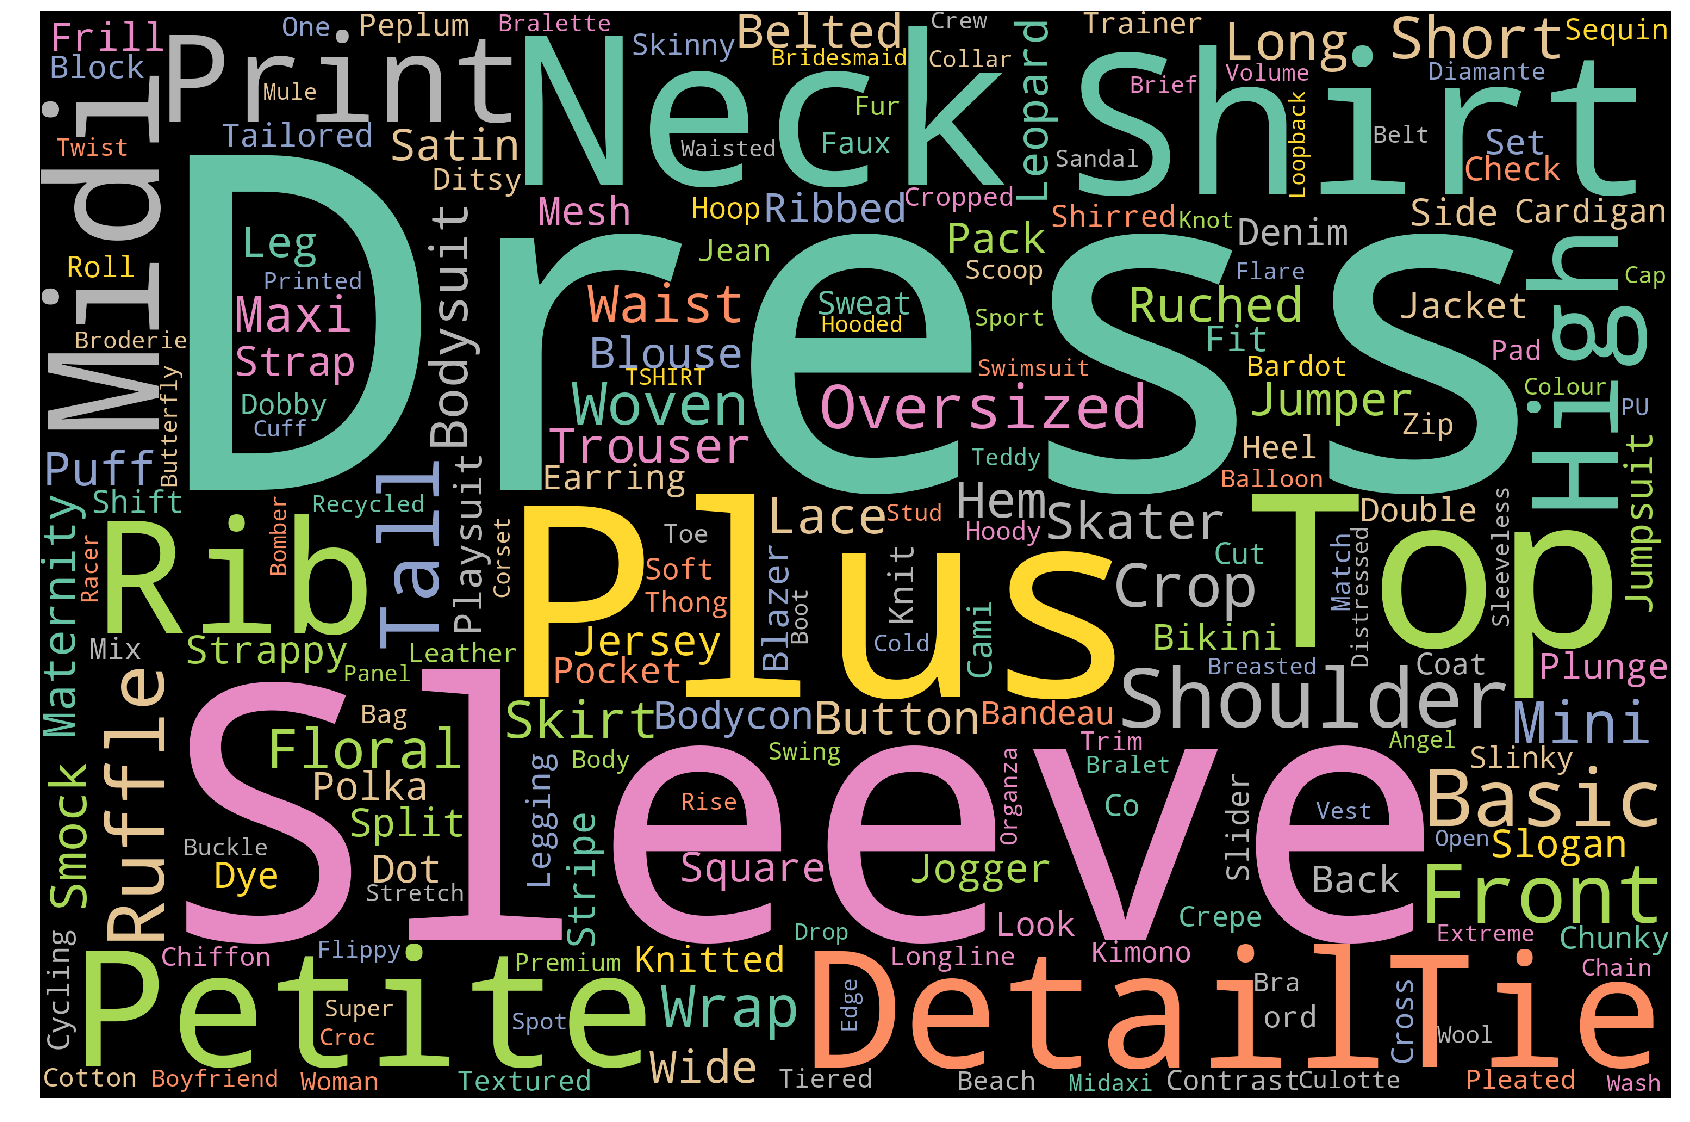



Gender:  Male


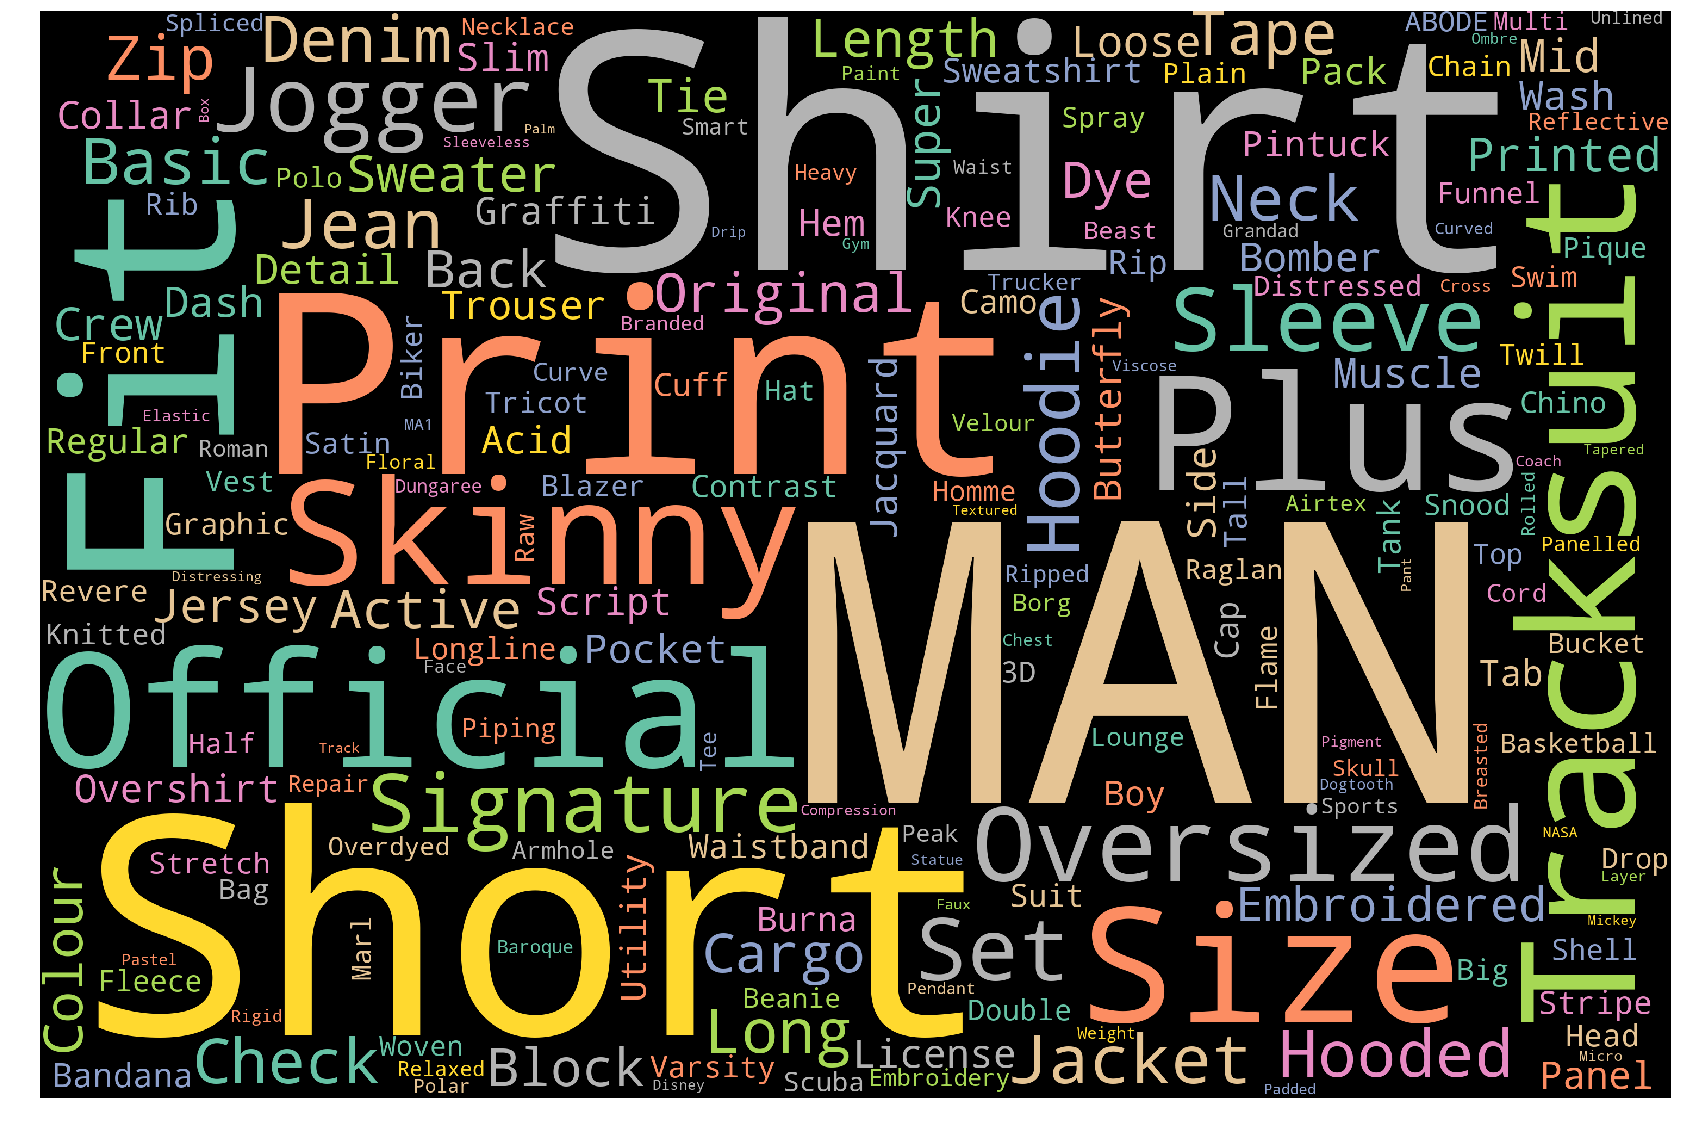

In [33]:
# word_cloud representation according to the gender
for g in ['Female', 'Male']:
    text = ' '.join(df[df.gender==g].title.values.tolist())

    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                          colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)

    # Plot
    print("Gender: ", g)
    plot_cloud(wordcloud)
    print('\n')

I use word cloud package to get an observation about items' words frequency in the data set. It seems that more female words items have higher frequencies than male words items (if we comapre words with small letters we remark that there is more small words for Male than Female gender. However this representation is hard to extract discriminant conclusion from it - a bag of words transformation will be more suitable.

# Tags Insights

Tags contains a lot information. I am going to study their representation according the items, the gender and also I am getting insights of NotTagged values.

I created a new variable which count the number of detected tags for each items.

In [35]:
# compute the numbers of classified tags for each items
df['tags_cnt'] = df[col_tags_prob].apply(lambda r: (r!=0).sum(), axis=1)

## Tags cnt vs items

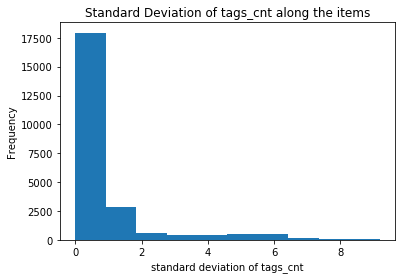

In [40]:
# distribution of std of tags_cnt
df.groupby('title').tags_cnt.std().fillna(0).plot.hist()
plt.title('Standard Deviation of tags_cnt along the items')
plt.xlabel('standard deviation of tags_cnt')
plt.show()

We observe that even if an item can have different combination of tags it can also a different number of tags detected (combination can be different but with the same number of tags). The majority of items did not repeat a lot in the dataset (positive skewness of the distribution), however certain items have a large possibilty of numbers of tags detected.

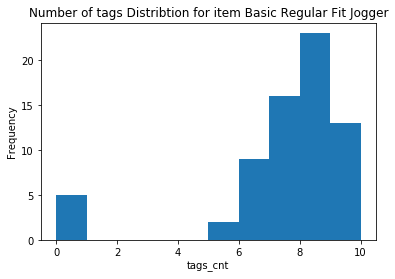

In [45]:
#plot distribution of tags_cnt for the items Basic Regular Fit Jogger
df[df.title=='Basic Regular Fit Jogger'].tags_cnt.plot.hist()
plt.title('Number of tags Distribtion for item Basic Regular Fit Jogger')
plt.xlabel('tags_cnt')
plt.show()

## Distribution of tags_cnt according to the gender

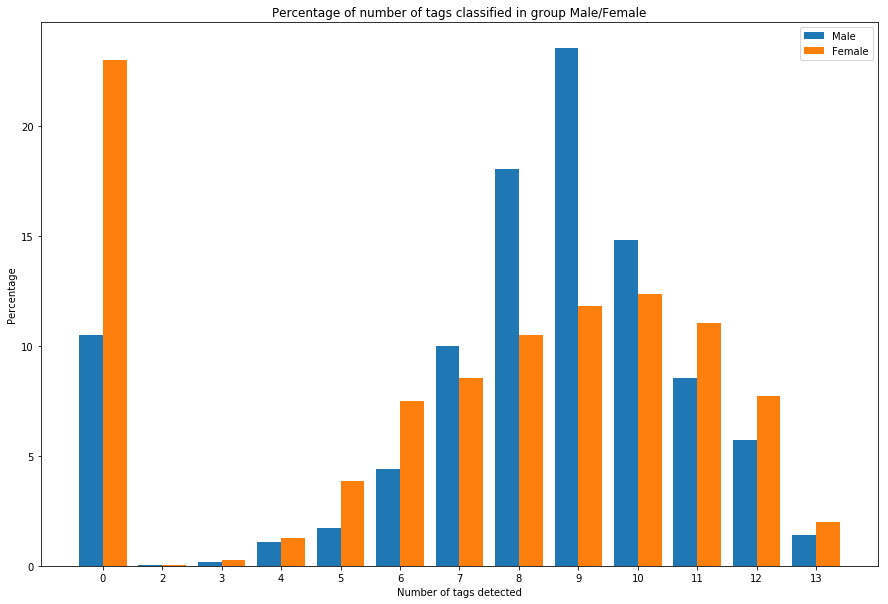

In [46]:
# plot Percentage of number of tags classified in group Male/Female
a = pd.pivot_table(df[['gender', 'tags_cnt']], index='tags_cnt', columns='gender', aggfunc='size', fill_value=0)

labels = a.index.tolist()
men_means = (a.Male*100/a.sum().Male).values.tolist()
women_means = (a.Female*100/a.sum().Female).values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, men_means, width, label='Male')
rects2 = ax.bar(x + width/2, women_means, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of tags detected')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of number of tags classified in group Male/Female')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.legend()
plt.show()

Tags discovery model detect more tags in average for male items than female items.
Male’s items are maybe more specific and Female’s items are widespread.

The variable 'tags_cnt' can be useful to predict the gender.

## items vs number of tags - wordCloud

Number of tags' items classified  0


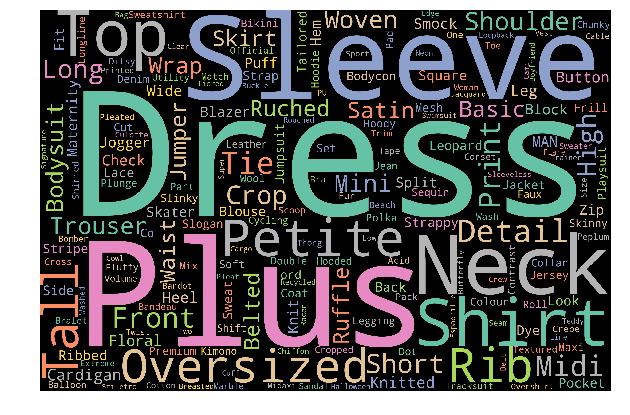



Number of tags' items classified  2


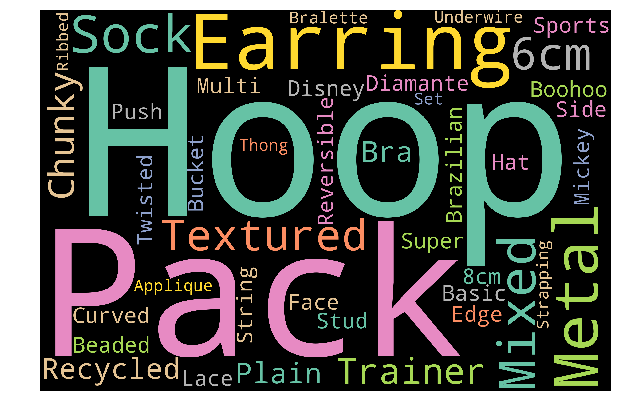



Number of tags' items classified  3


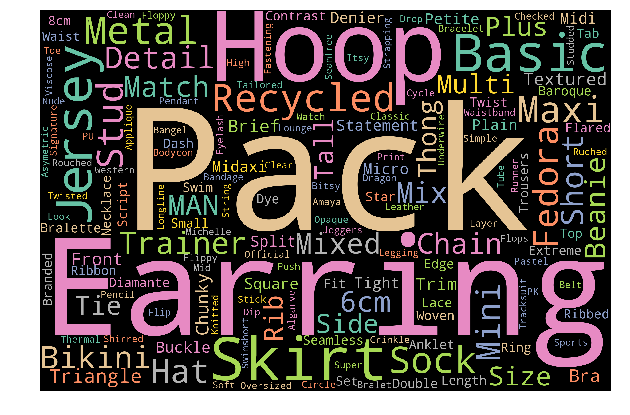



Number of tags' items classified  4


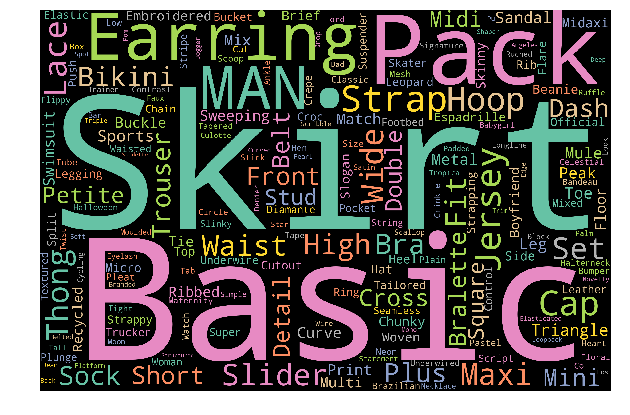



Number of tags' items classified  5


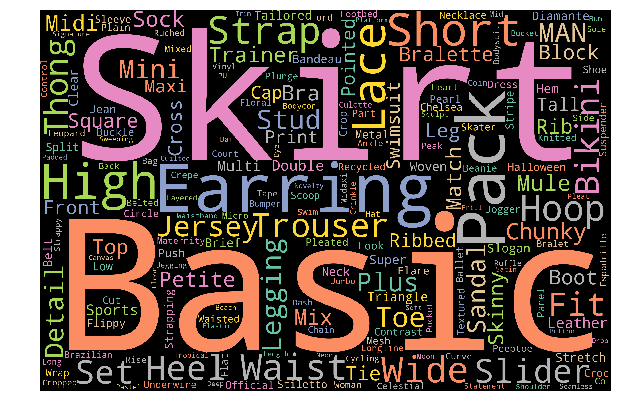



Number of tags' items classified  6


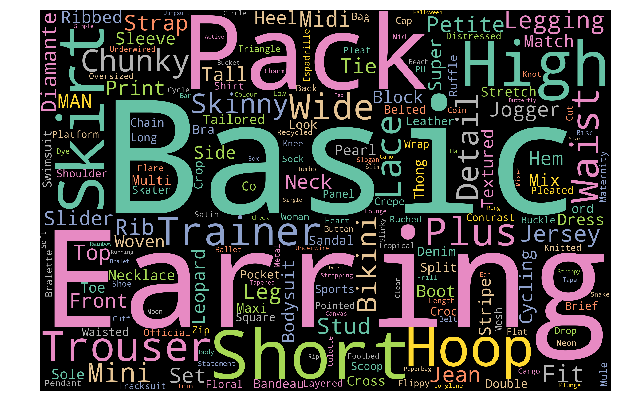



Number of tags' items classified  7


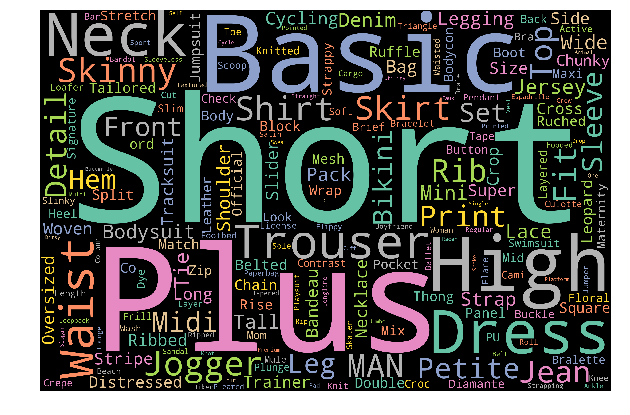



Number of tags' items classified  8


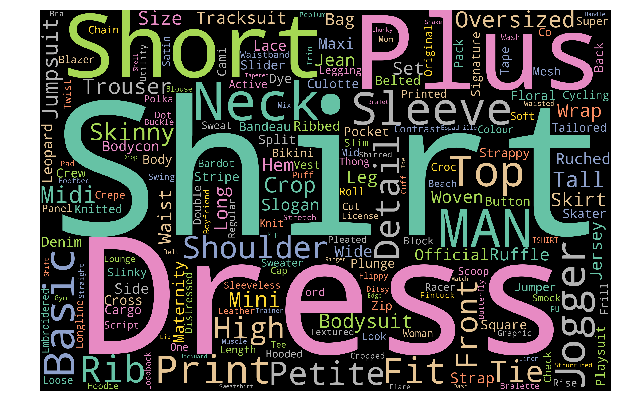



Number of tags' items classified  9


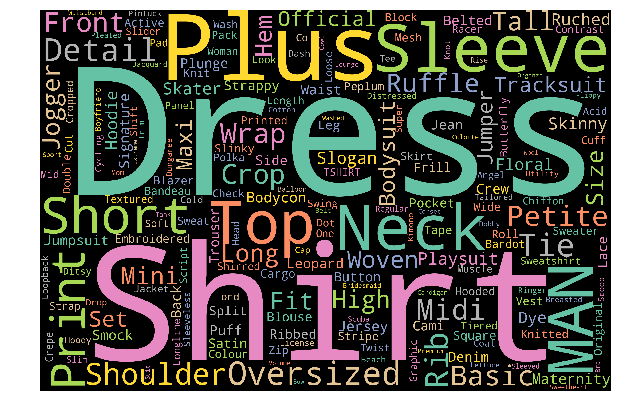



Number of tags' items classified  10


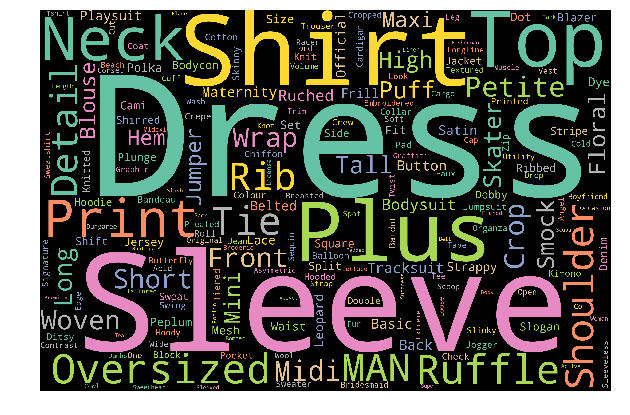



Number of tags' items classified  11


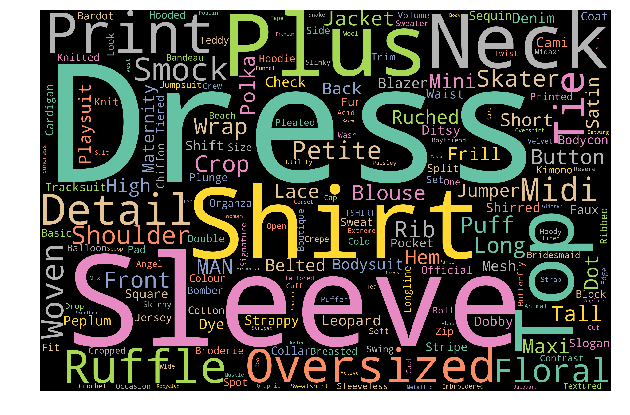



Number of tags' items classified  12


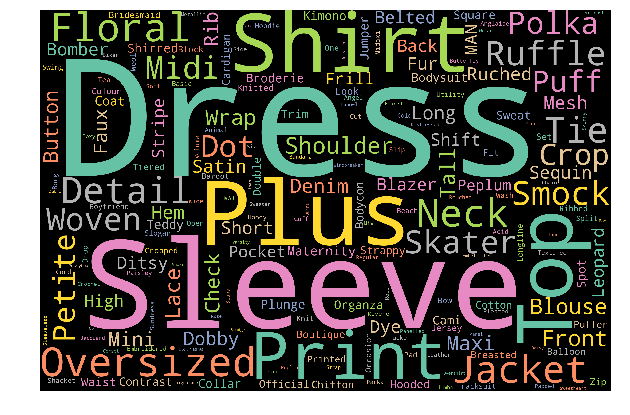



Number of tags' items classified  13


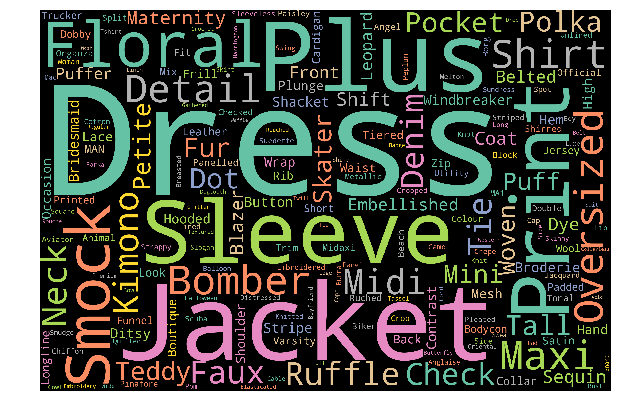

In [95]:
# plot word_cloud according to the tags_cnt
for n in labels:
    text = ' '.join(df[df.tags_cnt==n].title.values.tolist())

    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                          colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)

    # Plot
    print("Number of tags' items classified ", n)
    plot_cloud(wordcloud)
    print('\n')

I use again the word cloud representation to observe links between the frequency of items words and the number tags associated. I notice that some words are associated to the tags count but other not.
1. the word Jacket appears to be ferquent when the tags count is equal to 13 (maximum number of tags category)
2. Dress, Sleeve, Plus, Shirt, Plus are not really correlate with the number of tags.
3. When the number of tags is equal to 2, then specific words came out (Hoop, Pack, ..) which are not frequent in other tags count.

## Not Tagged

In [47]:
# when Cat is not tagged
df[df.Cat=='NotTagged'][col_tags_prob].sum()

Cat_prob               0.0
Type_prob              0.0
Look_prob              0.0
Color_prob             0.0
Texture_prob           0.0
Style_prob             0.0
Pattern_prob           0.0
Detail_prob            0.0
Embellishments_prob    0.0
Length_prob            0.0
Sleeve_prob            0.0
Neckline_prob          0.0
SleeveStyle_prob       0.0
dtype: float64

When computing the sum along the columns of tag category probabilities with category 'Cat' not tagged we obtain 0 everywhere. That result mean that when the 'Cat' is not tagged then no other categories is tagged.

In [48]:
# percentage of not tagged value for each categories
r = []
for col in col_tags:
    s = 100*df[df[col]=='NotTagged'].shape[0]/50000
    print(col+' percentage not tagged: ', s)
    r.append(s)

Cat percentage not tagged:  21.342
Type percentage not tagged:  37.844
Look percentage not tagged:  49.93
Color percentage not tagged:  22.944
Texture percentage not tagged:  41.276
Style percentage not tagged:  43.0
Pattern percentage not tagged:  61.76
Detail percentage not tagged:  41.59
Embellishments percentage not tagged:  63.43
Length percentage not tagged:  61.72
Sleeve percentage not tagged:  47.694
Neckline percentage not tagged:  46.892
SleeveStyle percentage not tagged:  61.064


In [49]:
# mean
np.mean(r)

46.19123076923077

In average, the tag categories are not tagged at 46%.

## Cat class vs number of tags

In [50]:
df.groupby(['gender','Cat']).tags_cnt.agg(['mean', 'median', 'skew']).reset_index().fillna(0)

,gender,Cat,mean,median,skew
0,Female,Bags,7.322946,8.0,-0.098004
1,Female,Belts,4.666667,4.0,0.968286
2,Female,Bracelets,6.094118,7.0,-1.386528
3,Female,Coats,11.094008,11.0,-0.657639
4,Female,Dress,10.209054,10.0,-0.346560
5,Female,Earrings,5.399225,6.0,-1.645981
6,Female,Gloves,5.750000,6.0,-0.386437
7,Female,Hats,4.114286,4.0,0.388648
8,Female,Jumpsuit,9.263026,9.0,-0.084820
9,Female,Kimonos,9.000000,9.0,0.000000


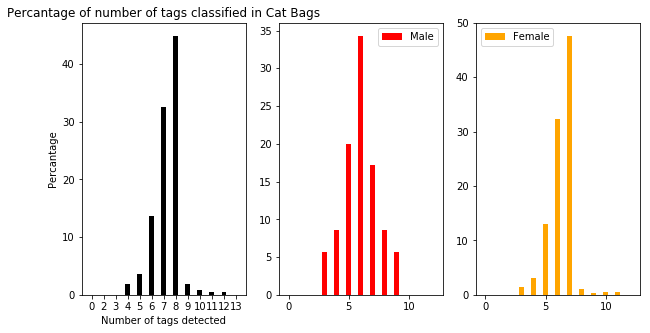

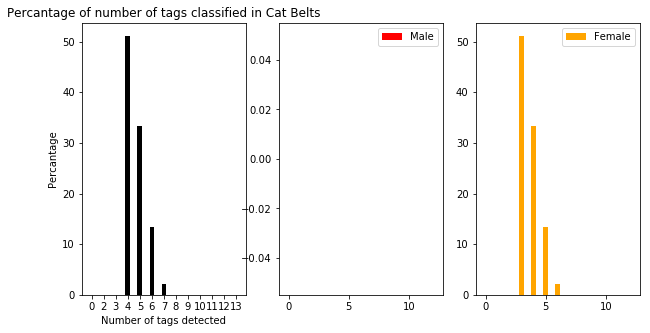

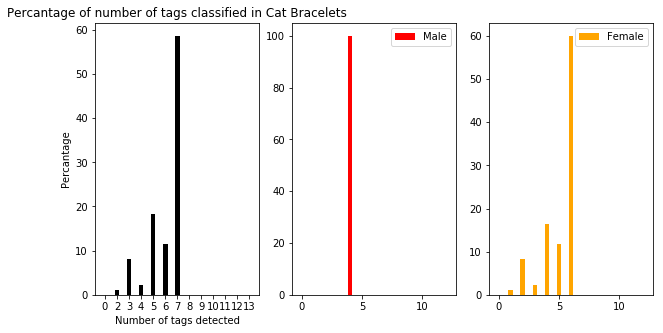

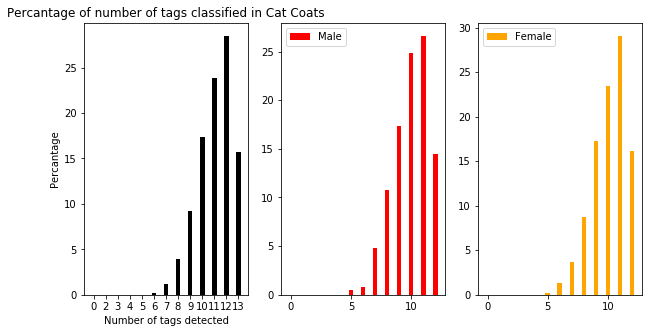

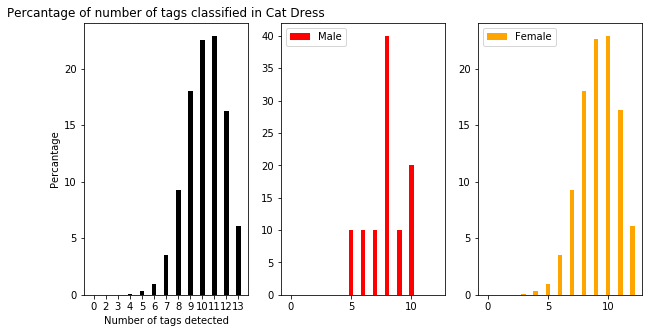

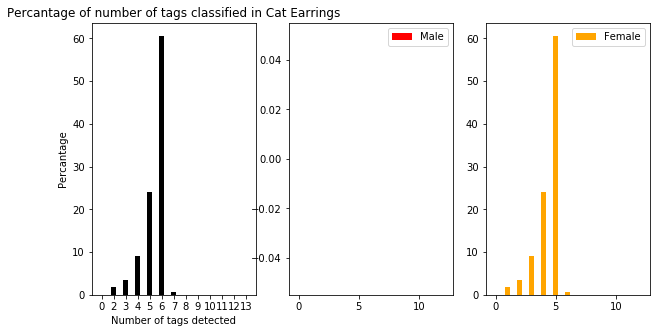

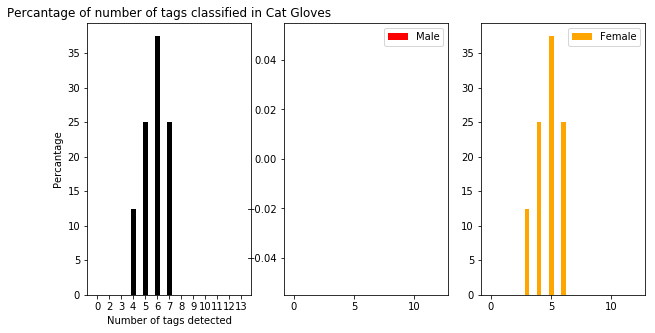

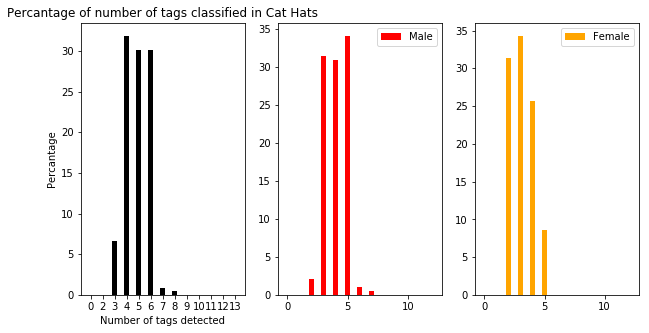

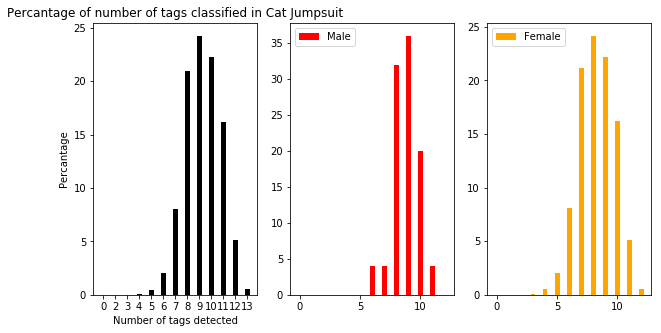

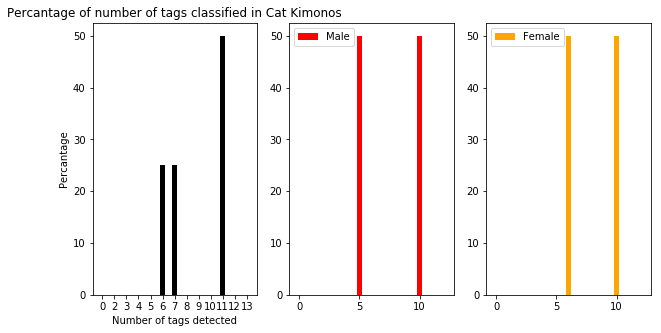

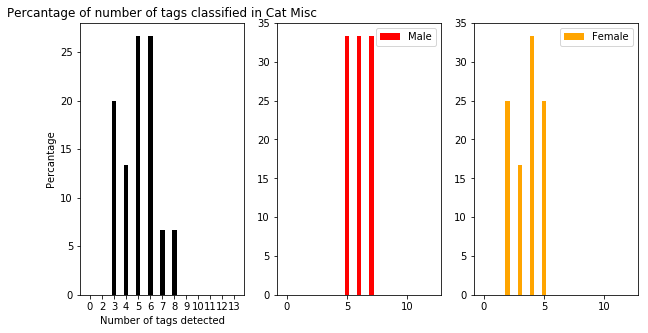

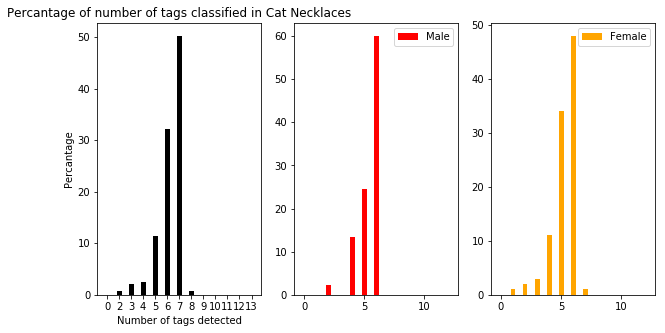

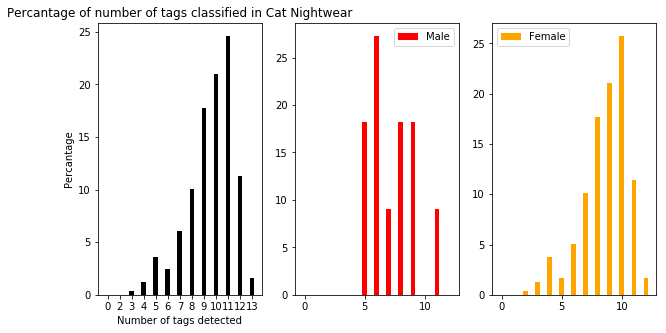

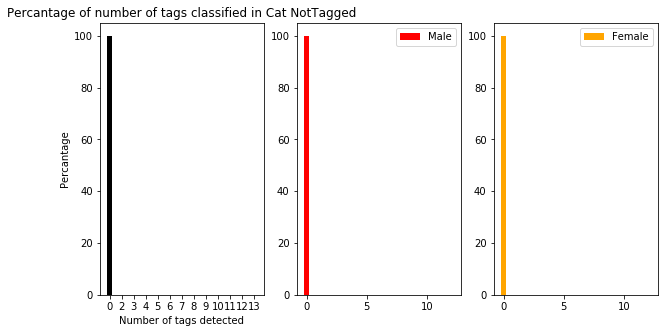

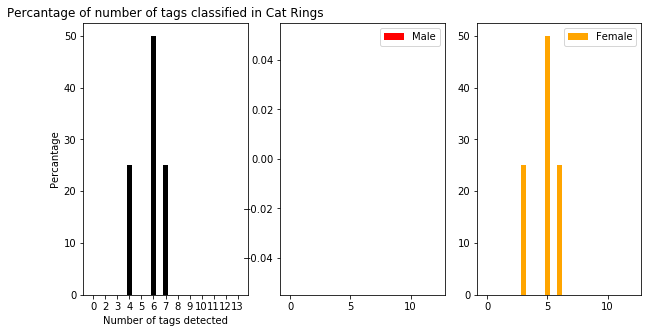

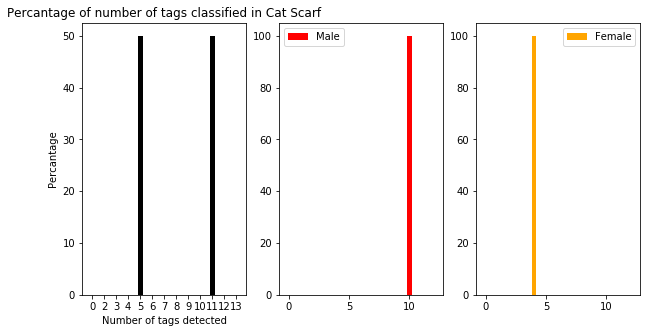

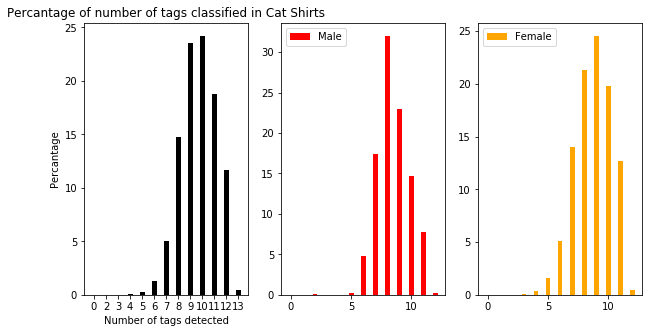

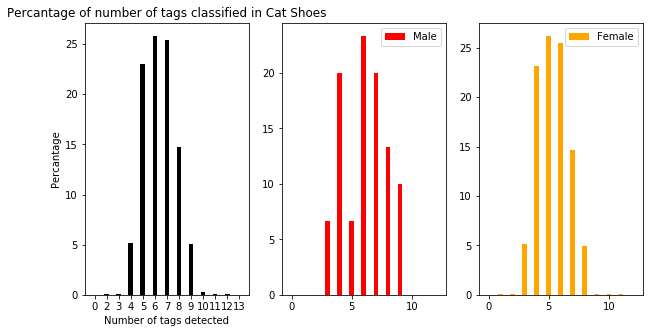

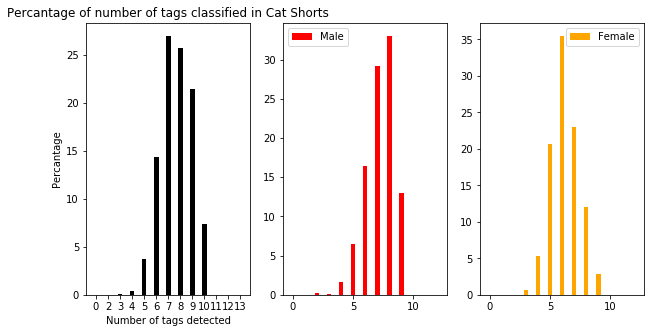

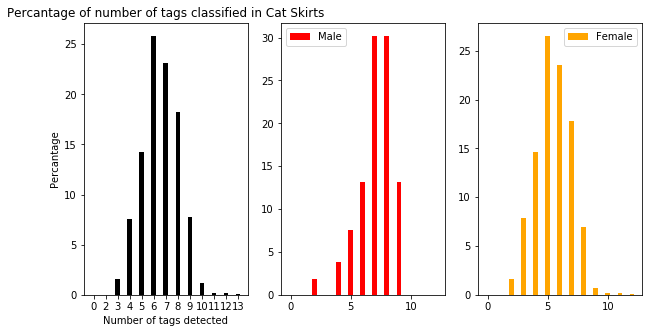

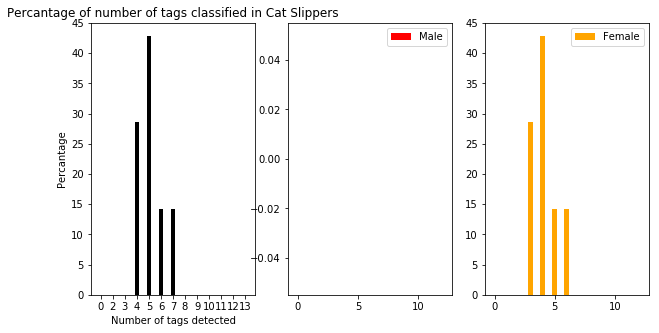

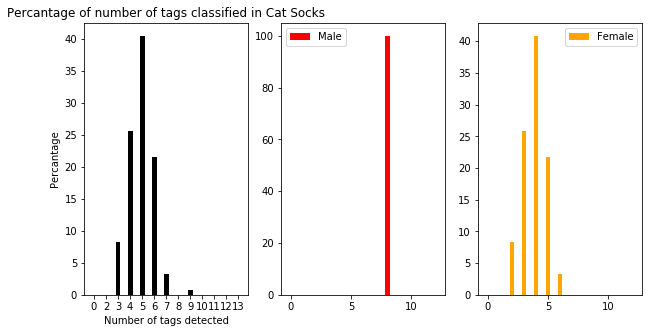

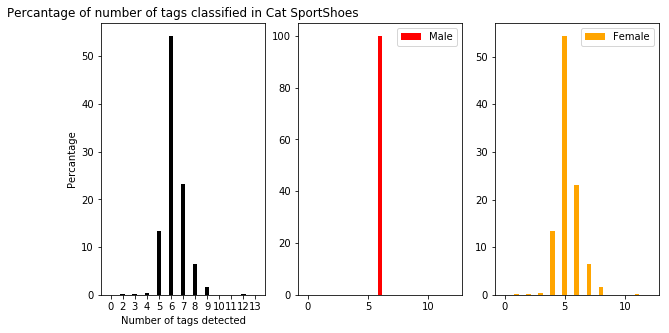

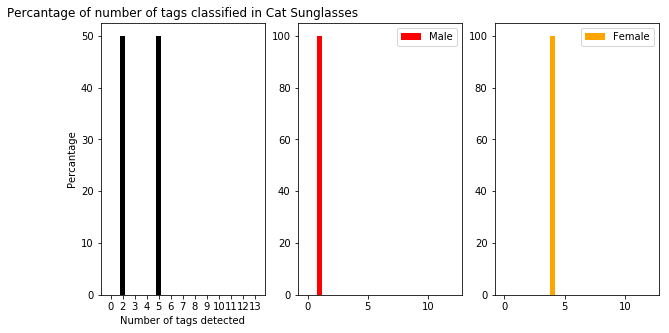

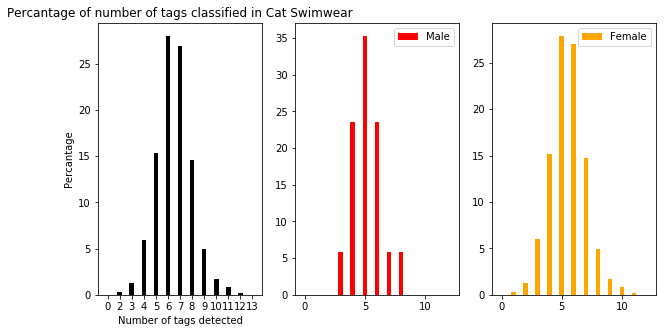

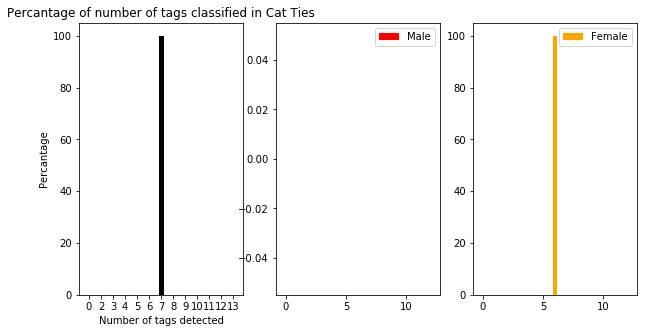

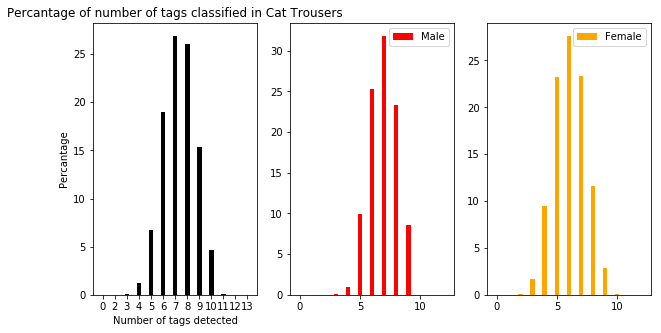

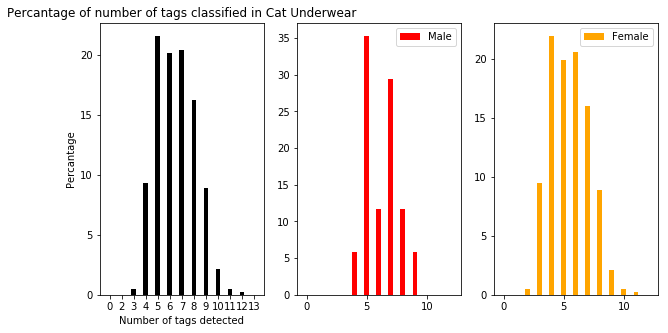

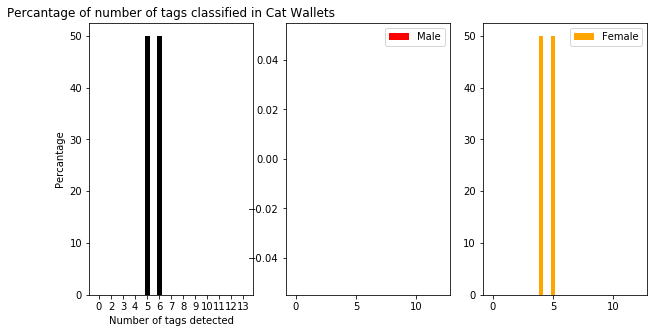

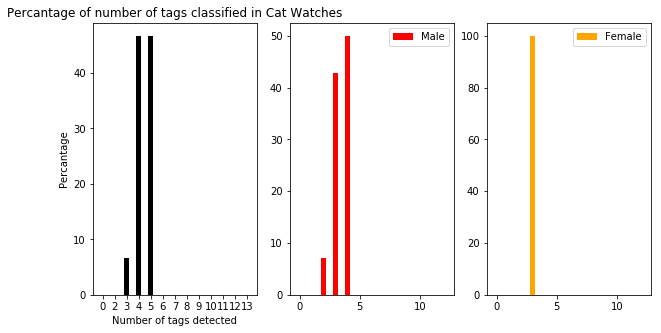

In [51]:
# distribution of tags_cnt according the the value of 'Cat' and the gender
a = pd.pivot_table(df[['Cat', 'tags_cnt']], index='tags_cnt', columns=['Cat'], aggfunc='size', fill_value=0)
a_male = pd.pivot_table(df[df.gender=='Male'][['Cat', 'tags_cnt']], index='tags_cnt', columns=['Cat'], aggfunc='size', fill_value=0)
a_female = pd.pivot_table(df[df.gender=='Female'][['Cat', 'tags_cnt']], index='tags_cnt', columns=['Cat'], aggfunc='size', fill_value=0)
labels = a.index.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

for cat in a.columns:
    val = 100*a[cat].values/a[cat].sum()
    try:
        val_male = 100*a_male[cat].values/a_male[cat].sum()
    except:
        val_male = np.zeros_like(val)
    try:
        val_female = 100*a_female[cat].values/a_female[cat].sum()
    except:
        val_female = np.zeros_like(val)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
    rects = ax1.bar(x, val, width, color='black')
    rects_male = ax2.bar(x, val_male, width, color='red', label='Male')
    rects_female = ax3.bar(x, val_female, width, color='orange', label='Female')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_xlabel('Number of tags detected')
    ax1.set_ylabel('Percantage')
    ax1.set_title('Percantage of number of tags classified in Cat '+cat)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0)
    ax2.legend()
    ax3.legend()
    plt.show()

The variable 'Cat' is affect the number tags detected. In fact, we can notice different distrition of tags count according to certain value of 'Cat'. Moreover, the gender modify the distributions also.

# Tags Probability

## Reliability of Tag discovery model

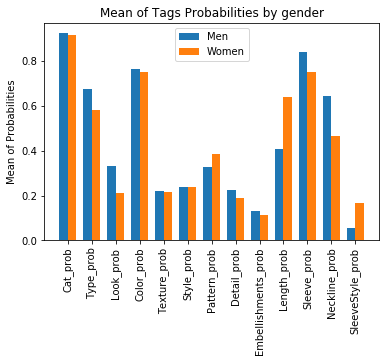

In [52]:
# average of probability for each tag categories
resm = []
resf = []
for col in col_tags_prob:
    xm = df[(df.gender=='Male')&(df[col]!=0)][col].values
    xf = df[(df.gender=='Female')&(df[col]!=0)][col].values
    resm.append(np.mean(xm))
    resf.append(np.mean(xf))

labels = col_tags_prob

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, resm, width, label='Men')
rects2 = ax.bar(x + width/2, resf, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean of Probabilities')
ax.set_title('Mean of Tags Probabilities by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

We observe that for some tags, the probabilities are low in average. It seems that the tag recognition model is more reliable for some tags than others. in addition, the gender do not change a lot the results.

Detection of tags ‘Cat’, ‘Type’, ‘Color’, ‘Length’, ‘Sleeve’ and ‘Neckline’ gives higher probabilities in average.

## 'Cat' Probabilities

Thanks to the previous observation we know the category 'Cat' is the most important (when it is not tagged, the others also). So, I decide to study the 'Cat's probabilities.

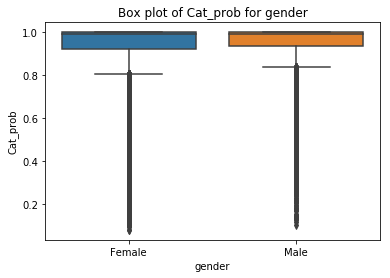

In [54]:
# box plot of 'Cat' propbabilities
sns.boxplot(x="gender", y="Cat_prob", data=df[df.Cat_prob!=0])
plt.title('Box plot of Cat_prob for gender')
plt.show()

I highlight again the reliability of 'Cat' probabilities (the model is pretty sure of what is detected)

In [58]:
# I am looking for items with low probabilities
df[(df[col_tags_prob].sum(axis=1)>0)&(df[col_tags_prob].sum(axis=1)<1)][['title', 'gender']+col_tags_prob].title

344      Bright Tie Dye Contrast Trim Runner Shorts 
352                Plus T-Shirt & Cycle Short Co-ord
1906                             6 Pack Trainer Sock
1907                             6 Pack Trainer Sock
1911                             6 Pack Trainer Sock
                            ...                     
48863            Ribbed Seamless Longline Lounge Bra
48864          Sheer Mesh Underwire Bra & String Set
48883                              Basic Lace Bralet
49067                       3 Pack Triangle Bralette
49936                     Miss To Mrs Slogan Sliders
Name: title, Length: 70, dtype: object

In [252]:
data[352]

{'title': 'Plus T-Shirt & Cycle Short Co-ord',
 'gender': 'Female',
 'tags': {'Color': 'White',
  'Color_prob': 0.5040146112442017,
  'Cat': 'Shorts',
  'Cat_prob': 0.19236654043197632,
  'Type': 'Tights',
  'Type_prob': 0.1288319230079651,
  'Length': 'Longline',
  'Length_prob': 0.046680960804224014,
  'Texture': 'Leather',
  'Texture_prob': 0.026562698185443878,
  'Style': 'Biker',
  'Style_prob': 0.015788961201906204,
  'Look': 'Casual',
  'Look_prob': 0.010981176979839802}}

In [254]:
data[2891]

{'title': 'Plus T-Shirt & Cycle Short Co-ord',
 'gender': 'Female',
 'tags': {'Cat': 'Shorts',
  'Cat_prob': 0.9880670309066772,
  'Type': 'Tights',
  'Type_prob': 0.9276415705680847,
  'Color': 'Gray',
  'Color_prob': 0.7963474988937378,
  'Length': 'Longline',
  'Length_prob': 0.7677823901176453,
  'Look': 'Sportive',
  'Look_prob': 0.5947440266609192,
  'Style': 'Biker',
  'Style_prob': 0.5389992594718933,
  'Texture': 'Cotton',
  'Texture_prob': 0.10073894262313843}}

With the item Plus T-Shirt & Cycle Short Co-ord, tags probabilities can have different values for the same tag on the same item. Tags probabilities are dependent on each other but the tags are. If a tag is misclassified it can affect the others. 

From that observation, I want to assume that the recognition of 'Cat' and its probability can modify all the others tags recognition.

In [59]:
df[df.Cat_prob!=0].groupby(['gender'])[col_tags_prob].agg(['median']).fillna(0).T

,gender,Female,Male
Cat_prob,median,0.989639,0.992006
Type_prob,median,0.405808,0.772100
Look_prob,median,0.021853,0.187775
Color_prob,median,0.891053,0.890964
Texture_prob,median,0.040630,0.052174
Style_prob,median,0.048064,0.015876
Pattern_prob,median,0.000000,0.094700
Detail_prob,median,0.047758,0.037493
Embellishments_prob,median,0.000000,0.000000
Length_prob,median,0.000000,0.000000


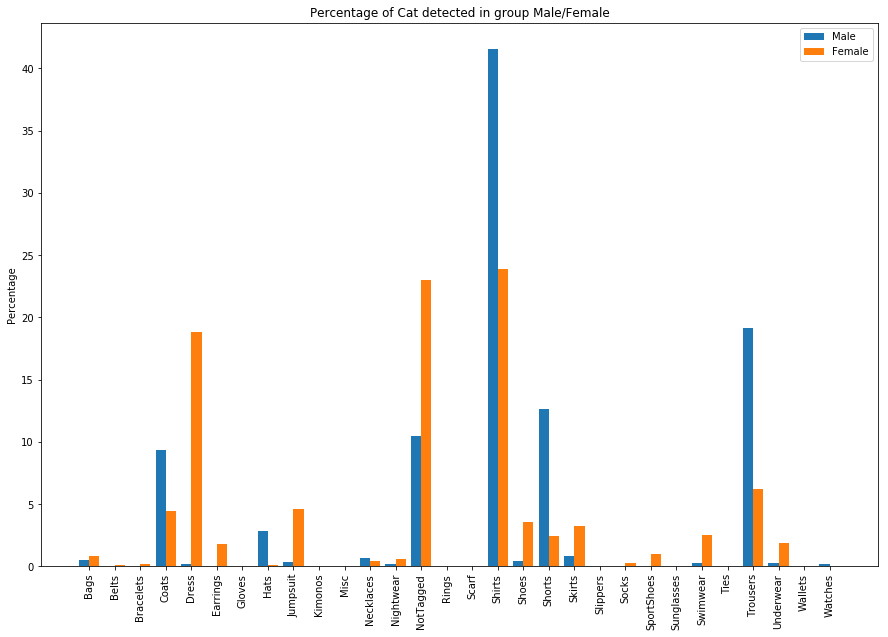

In [62]:
a = pd.pivot_table(df[['gender', 'Cat']], index='Cat', columns='gender', aggfunc='size', fill_value=0)

labels = a.index.tolist()
men_means = (a.Male*100/a.sum().Male).values.tolist()
women_means = (a.Female*100/a.sum().Female).values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, men_means, width, label='Male')
rects2 = ax.bar(x + width/2, women_means, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Cat detected in group Male/Female')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

For Male group, I see that they buy mostly:
1. 40% detected Shirts
2. 20% detected Trousers
3. 12% detected Shorts
4. 10% Coats

For Female group, I see that they buy mostly:
1. 23% detected Shirts
2. 18% detected Dress
3. Coats, Jumpsuit, Shoes, Shorts, Skirts, Trousers have equivalent percentages and together represent 30%

I notice that a lot of categories are not detected according to the gender (male or female) and  21% of Cat is classify as NotTagged.

# Predict Gender

The aim goal is to predict the gender according all others variables:
1. title of items
2. tags category
3. tags probability

I am starting by applying features engineering on the dataset. Then I am using the RandomForestClassifier algorithm for predicting the gender. I see several pros for using that model:
1. Can handle large dataset with high dimensionality (50k rows and at least 27 variables).
2. Can estimate missing data (if we consider the value 'NotTagged' as missing data).
3. Can use out of bag dataset to study its performance. (if needed)
4. Can find significant variables. (if needed)

Moreover, we don t need to explain the model, we can use a black box approach and the data is not noisy.

In [131]:
# boostrap ooption for oversampling
# ll = []
# for col in col_tags:
#     col_val_cnt = df[col].value_counts().reset_index()
#     median_tag_cont = int(np.median(col_val_cnt[col].values))
    
#     for idx in col_val_cnt[col_val_cnt[col]<median_tag_cont]['index']:
#         data = df[df[col]==idx]
#         n_samples = median_tag_cont - col_val_cnt[col_val_cnt['index']==idx][col].values[0]
#         boot = resample(data, replace=True, n_samples=n_samples, random_state=1)
#         ll.append(boot)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import FeatureHasher

from collections import defaultdict
import re
from sklearn.utils import resample

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report, auc, average_precision_score, fbeta_score, matthews_corrcoef

## Features Engineering on full dataset

The main feature engineering we apply is LabelEncoding, however, encods before to split the data can lead to data leakage. But the target variable is only Male(1) and Female(0) and we assume that the cardinality of each tags is fixed.

### Reset dataset

In [64]:
dfX = df.drop(['gender', 'items_words_cnt', 'tags_cnt'], axis=1)
dfy = df[['gender']]

### Label encoding on Tags values

In [65]:
dict_le_col_tags = {}
for col in col_tags:
    lbl_encoder = LabelEncoder()
    dfX[col] = lbl_encoder.fit_transform(dfX[col])
    dict_le_col_tags[col] = lbl_encoder

### Label replacement for gender

In [66]:
dfy = dfy.replace({'gender': {'Male': 1, 'Female': 0}})

## Stratified train test split

Because the data is imbalanced, we want to keep track of that information in the train and test sets, so we use a stratified split.

In [68]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(dfX, dfy, test_size=0.2, random_state=42, stratify=dfy)

## Feature engineering on train set

For now, we apply a feature engineering on the train set only focusing on the title and tags.

### Feature Engineering on title

A lot of solution exists to handle the variable title. It can considered as a categorical variable with high cardinality.

In this paper, they describe solutions for this kind of variable.
https://hal.inria.fr/hal-02171256v1/document#:~:text=The%20classic%20approach%20to%20encode,feature%20vectors%20of%20high%20dimensionality.
I tried but my computer crashed several times. thus, I decide to use again the variable items_words_cnt because I know it is a discriminant variable for gender. In addition, I use also the variable tags_cnt for the same reason.

#### Embedding tf-idf (reweighting) + DimRed SVD on title

https://hal.inria.fr/hal-02171256v1/document#:~:text=The%20classic%20approach%20to%20encode,feature%20vectors%20of%20high%20dimensionality.

In [21]:
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df.title.values.tolist())
# feature_names = vectorizer.get_feature_names()
# dense = vectors.todense()
# denselist = dense.tolist()
# tfidf = pd.DataFrame(denselist, columns=feature_names)

# svd = TruncatedSVD(n_components=2, random_state=42)
# svdFit = svd.fit_transform(tfidf.values)

#### Feature Hashing

In [24]:
# def n_nonzero_columns(X):
#     """Returns the number of non-zero columns in a CSR matrix X."""
#     return len(np.unique(X.nonzero()[1]))


# def tokens(doc):
#     """Extract tokens from doc.

#     This uses a simple regex to break strings into tokens. For a more
#     principled approach, see CountVectorizer or TfidfVectorizer.
#     """
#     return (tok.lower() for tok in re.findall(r"\w+", doc))


# def token_freqs(doc):
#     """Extract a dict mapping tokens from doc to their frequencies."""
#     freq = defaultdict(int)
#     for tok in tokens(doc):
#         freq[tok] += 1
#     return freq

# raw_data = dfX_train.title.values.tolist()

# hasher = FeatureHasher(n_features=1, input_type="string")
# X = hasher.transform(tokens(d) for d in raw_data)
# X.toarray()

#### Simple feature engineering - count of words in items title

In [69]:
dfX_train['title'] = dfX_train.title.apply(lambda t: len(t.split(' ')))

/home/elbaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Feature engineering on the number of tags detected

In [70]:
dfX_train['tags_cnt'] = dfX_train[col_tags_prob].apply(lambda r: (r!=0).sum(), axis=1)

/home/elbaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Feature engineering pipeline

In [71]:
def feat_eng_pipeline(dfX):
    dfX['title'] = dfX.title.apply(lambda t: len(t.split(' ')))
    dfX['tags_cnt'] = dfX[col_tags_prob].apply(lambda r: (r!=0).sum(), axis=1)
    return dfX

## Gender Prediction Model

### set Xs and ys

In [72]:
dfX_test = feat_eng_pipeline(dfX_test)

/home/elbaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/elbaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
X_train = dfX_train.values
X_test = dfX_test.values
y_train = dfy_train.values.reshape(-1)
y_test = dfy_test.values.reshape(-1)

## Random Forest

In [74]:
clf = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=50, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=50)

In [76]:
# get the class predicted
y_pred = clf.predict(X_test)
# get the probabilities of the predictions
y_pred_prob = clf.predict_proba(X_test)

### Model evaluation

#### Confusion Matrix

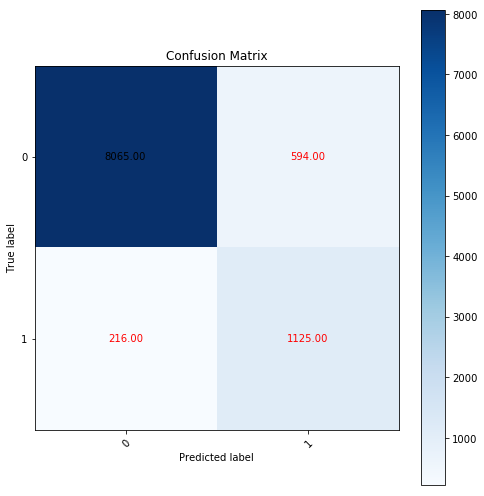

In [78]:
plot_confusion_matrix(y_test, y_pred)

In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [91]:
recall = tp/(tp+fn)
print(recall)

0.8389261744966443


In [93]:
precision = tp/(tp+fp)
print(precision)

0.6544502617801047


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8659
           1       0.65      0.84      0.74      1341

    accuracy                           0.92     10000
   macro avg       0.81      0.89      0.84     10000
weighted avg       0.93      0.92      0.92     10000



From the confusion matrix and the classification report we see that the model perform very well for predicting Female class. To predict Male class we see that the model has a better recall than precision. 

If we **assume that predict Male class is more important**, we can say we want to predict the most of Male class in the unseen dataset, it means have a low number of False Negatif.

A good metric for that purpose is the recall (true positive rate TPR) and the model gets a recall of 0.84 that is pretty good.

#### The ROC curve and AUC

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied and does not depend on the class distribution.

It plots the curve of TPR function of the FPR.

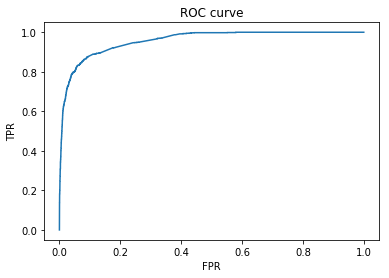

In [95]:
fpr_rf, tpr_rf, throc = roc_curve(y_test, y_pred_prob[:,1])
plt.plot(fpr_rf, tpr_rf)
plt.title("ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

We notice that the ROC curve is near to point (1,0) what shows the good performance of the model. We can also compute the aera under ROC curve (AUC) which measure the quality of the model.

In [85]:
auc(fpr_rf, tpr_rf)

0.9576681971032885

We obtain a ROCAUC of 0.96. Very close to 1, the model has a very good quality of predictions.

#### Precision - Recall Curve

Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class).

A model with perfect skill is depicted as a point at a coordinate of (1,1). A skillful model is represented by a curve that bows towards a coordinate of (1,1). A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.

The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models.

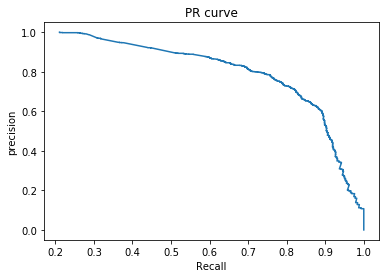

In [96]:
precision_rf, recall_rf, thpr = precision_recall_curve(y_test, y_pred_prob[:,1])
plt.plot(precision_rf, recall_rf)
plt.title("PR curve")
plt.xlabel('Recall')
plt.ylabel('precision')
plt.show()

We see here that the model has less performance in precision than in recall. But like the ROC curve, we can compute the area under the PR curve. The score can then be used on a binary classification problem where a score of 1.0 represents a model with perfect skill.

In [87]:
auc(recall_rf, precision_rf)

0.832069513680969

We obtain a PRAUC of 0.83. Even with less precision, the model can be discriminant for predicting gender.

#### F1 score and Matthews Correlation Coefficient

the F1 score which is the harmonic mean of the precision and recall and focus on true positive label.

In [88]:
fbeta_score(y_test, y_pred, beta=1)

0.7352941176470589

An other metric can be interesting to use is MCC score (Mathews Correlation Coefficient). If we decide to focus also on the true negative value and take in account the size of the four classes tp,fp,fn and tn.

In [89]:
matthews_corrcoef(y_test, y_pred)

0.6957353410834933

### Model evaluation Conclusion

Obviously the model trained has a lack of performance even if that one is relevant to predict into an unseen dataset the gender.

1. the recall = 0.84
2. the precision = 0.65
3. the roc_auc = 0.96
4. the pr_auc = 0.83

I want to conclude on its evaluation sayinf that this model perform well. For increasing its performances, many options are possible:
1. Tune the hyperparameter of the RandomForest model using out-of-bag dataset as validation set.
2. try another model (I am thinking a boosting model like AdaBoost).
3. Apply more features engineering for finding more discriminant variable.

### Model limitation Study

How can we improve the model if a mistake in classifying male is equal to
five mistakes in classifying females (classifying male correctly is more important
than classifying females correctly).

Male misclassification refers to False Negative value and can be evaluate with the FNR (false negative rate) which express the ability of the model to miss positive value. In other hands, Female misclassification can be evaluated with the FPR (false positve rate) which express the ability of the model to mistaken a positive value (or to miss a negative value).
We can observe the behavior of the FNR and FPR along different values of threshold. To compute the both and plot, I am using the results from the roc curve because the FNR is equal to 1-TPR.

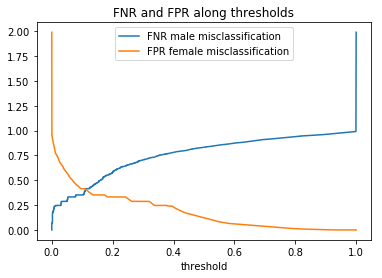

In [97]:
plt.plot(1-tpr_rf, throc, label='FNR male misclassification')
plt.plot(fpr_rf, throc, label='FPR female misclassification')
plt.title('FNR and FPR along thresholds')
plt.xlabel('threshold')
plt.legend()
plt.show()

First remark, FNR=FPR when the threshold is around 0.1. After that point the FNR keeps increasing. We can notice that the FNR is equal to 5 times the FPR when the threshold is around 0.6. 

Because detecting Male is more import than detecting Female, for imporving the model we need to reduce the threshold (it moves to the left).

In [99]:
def clf_by_th(y_pred_prob, th):
    y = np.zeros_like(y_pred_prob)
    for i,p in enumerate(y_pred_prob):
        if p>=th:
            y[i]=1
    return y


In [100]:
yy = clf_by_th(y_pred_prob[:,1], 0.3)

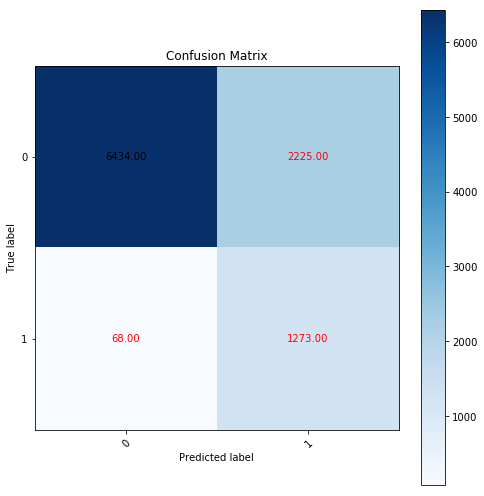

In [101]:
plot_confusion_matrix(y_test, yy)

In [102]:
print(classification_report(y_test, yy))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8659
           1       0.36      0.95      0.53      1341

    accuracy                           0.77     10000
   macro avg       0.68      0.85      0.69     10000
weighted avg       0.91      0.77      0.81     10000



We notice that the recall increases to 0.95.